In [1]:
import numpy as np
import pandas as pd

In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#from sklearn import neighborssum
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder, StandardScaler


%matplotlib inline


#building the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier 

## 🩺 Background of this notebook:
The healthcare insurance system in the United States primarily consists of two parts: social insurance and commercial insurance. Social insurance mainly provides free medical insurance for the elderly, low-income groups, and retired veterans. For the majority of the general population, purchasing commercial insurance is the only option. In 2021, healthcare expenditure in the United States accounted for approximately 18% of the GDP, and the immense volume makes the healthcare system a target for fraud.



Medical insurance fraud results in significant economic losses, reduces the efficiency of the healthcare system, and affects the quality of medical services. This issue has become one of the biggest challenges in the U.S. healthcare system.

Traditional manual methods of identifying medical insurance fraud have high thresholds and are inefficient. Therefore, there is a need to reduce costs and improve efficiency in fraud identification, as well as better handling claims and identifying potential fraudulent activities.

Medical insurance fraud can be caused by multiple entities, including patients (or beneficiaries), healthcare service providers, and insurance providers. In this case study, our focus is primarily on fraudulent activities caused by providers in the insurance claims submitted to insurance agencies.

We can build a machine learning model to determine whether claim records exhibit fraudulent behavior. Regarding the model, it is essential to ensure interpretability of the results, providing appropriate reasons for identifying cases as fraudulent. In terms of errors, a higher false positive rate may be acceptable, but efforts should be made to minimize false negative rates. There is no strict requirement on computational speed.

## Read the data

In [3]:
# beneficiary data
bene_train = pd.read_csv(r'C:\Users\hp\Downloads\Train_Beneficiarydata-1542865627584.csv')
bene_test= pd.read_csv(r'C:\Users\hp\Downloads\Test_Beneficiarydata-1542969243754.csv')

# inpatient data
inp_test = pd.read_csv(r'C:\Users\hp\Downloads\Test_Inpatientdata-1542969243754.csv')
inp_train = pd.read_csv(r'C:\Users\hp\Downloads\Train_Inpatientdata-1542865627584.csv')

# outpatient data
outp_test= pd.read_csv(r'C:\Users\hp\Downloads\Test_Outpatientdata-1542969243754.csv')
outp_train = pd.read_csv(r'C:\Users\hp\Downloads\Train_Outpatientdata-1542865627584.csv')

#label data
label_train = pd.read_csv(r'C:\Users\hp\Downloads\Train-1542865627584.csv')
label_test = pd.read_csv(r'C:\Users\hp\Downloads\Test-1542969243754.csv')


## Beneficiary data

In [4]:
bene_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

## EDA of the beneficiary data (the train set)

In [5]:
bene_train.shape, bene_test.shape

((138556, 25), (63968, 25))

In [6]:
bene_train.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')

**Gender distribution of the data**

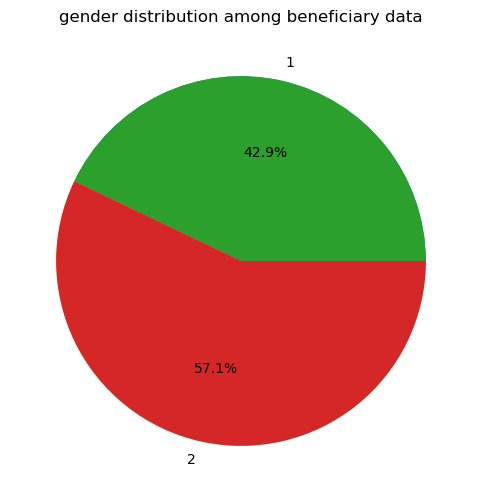

In [7]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

plt.figure(figsize=(8,6),dpi=100)

data=bene_train.groupby('Gender').count().BeneID
fig = plt.pie(data,
              labels=data.index,
              autopct = lambda pct: func(pct, data.values),)
plt.title("gender distribution among beneficiary data")

fig = plt.pie(data)

## Adding new feature and dropping features that are irrelevent

In [8]:
bene_train['RenalDiseaseIndicator'][:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    Y
9    0
Name: RenalDiseaseIndicator, dtype: object

In [9]:
# this value indicates whether the beneficiary has renal disease
bene_train['RenalDiseaseIndicator'].replace('Y','1',inplace=True)
bene_train['RenalDiseaseIndicator'] = bene_train['RenalDiseaseIndicator'].astype(int)   
bene_test['RenalDiseaseIndicator'].replace('Y','1',inplace=True)
bene_test['RenalDiseaseIndicator'] = bene_test['RenalDiseaseIndicator'].astype(int)
    

### Data Reduction: Delete DOD DOB and change it into new feature 'Age' and 'Alive'

In [10]:
for col in ['DOB','DOD']:  
    bene_train[col] = pd.to_datetime(bene_train[col])
    bene_test[col] = pd.to_datetime(bene_test[col])


bene_train['BirthYear'] = bene_train['DOB'].dt.year
bene_test['BirthYear'] = bene_test['DOB'].dt.year


# Greatest Date of Death in the TRAIN set for beneficiaries
max_bene_DOD = max(bene_train['DOD'].unique()[1:])
# For all NAN DODs filling the greatest Date of Death
bene_train['DOD'].fillna(value=max_bene_DOD, inplace=True)

# Same thing for the test set
max_bene_DOD = max(bene_test['DOD'].unique()[1:])
# For all NAN DODs filling the greatest Date of Death
bene_test['DOD'].fillna(value=max_bene_DOD, inplace=True)


bene_train['Age'] = round(((bene_train['DOD'] - bene_train['DOB']).dt.days)/365,0)
bene_test['Age'] = round(((bene_test['DOD'] - bene_test['DOB']).dt.days)/365,0)

In [11]:
bene_train['Alive'] = bene_train['DOD'].apply(lambda x: 1 if x != x else 0)
bene_test['Alive'] = bene_test['DOD'].apply(lambda x: 1 if x != x else 0)

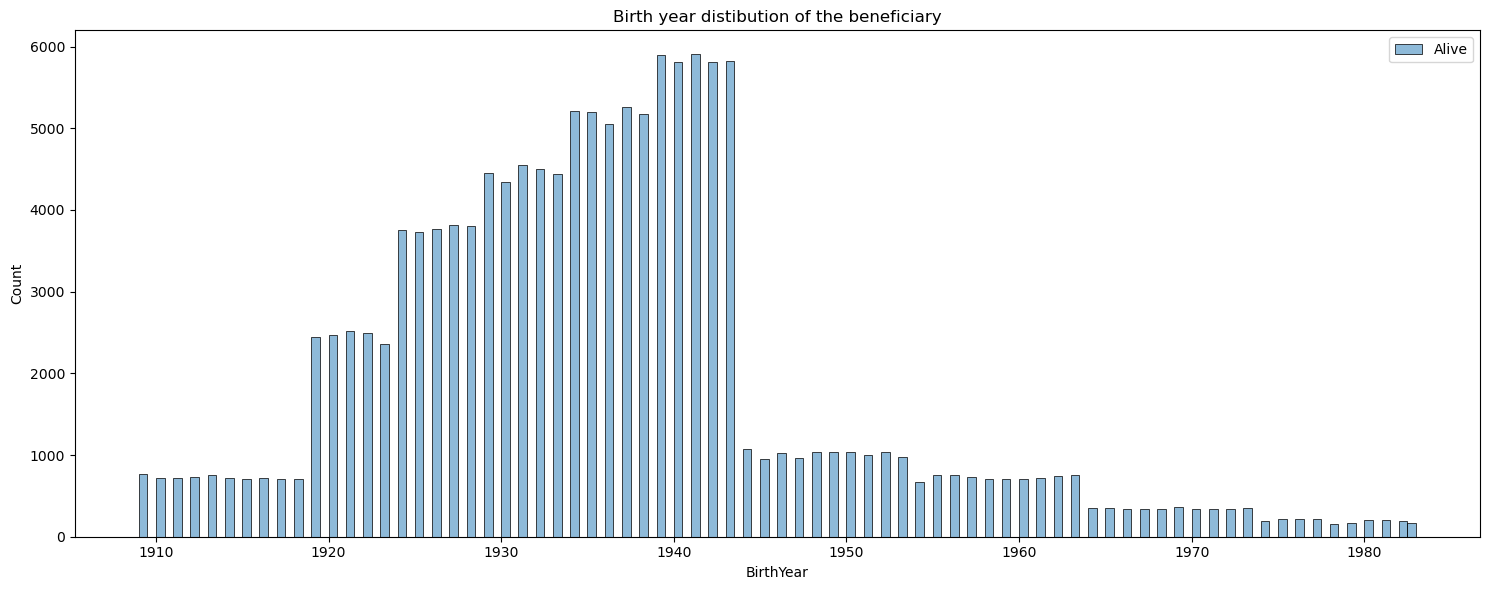

In [12]:
fig, ax = plt.subplots(figsize=(15,6),dpi=100)

sns.histplot(data=bene_train,x='BirthYear',hue='Alive',legend=False,ax=ax)
plt.legend(['Alive','Dead'])
plt.title('Birth year distibution of the beneficiary')
#fig = plt.bar(x=bene_train['BirthYear'].value_counts().index, height = bene_train['BirthYear'].value_counts())
plt.tight_layout()
plt.show()

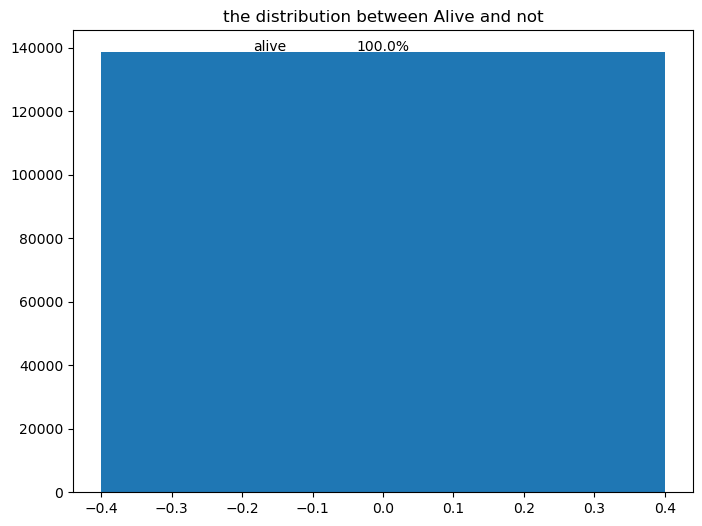

In [13]:
plt.figure(figsize=(8,6))

fig = plt.bar(x=bene_train['Alive'].value_counts().index, height = bene_train['Alive'].value_counts())
plt.title('the distribution between Alive and not')
label = ['alive','dead']
# plt.xticks()
cnt = 0
for p in fig.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    plt.annotate(label[cnt],(x+width/3.35,y+height+280),ha='center')
    plt.annotate(f'{str(round((100*height)/(bene_train["Alive"].shape[0]),2))+"%"}',(x+width/2,y+height+280),ha='center')
    cnt+=1

plt.show()

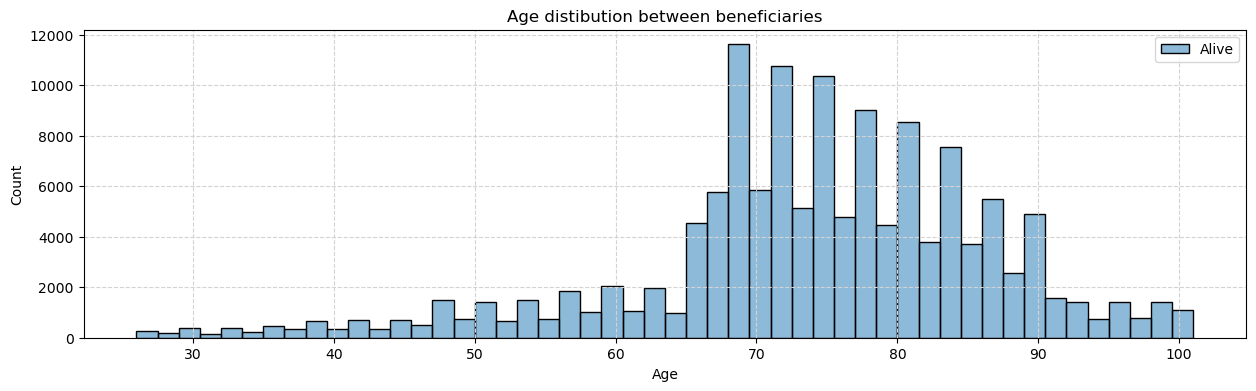

In [14]:
fig, ax = plt.subplots(figsize=(15,4),dpi=100)
ax.grid( linestyle="--", color='lightgrey')
plt.title('Age distibution between beneficiaries')

sns.histplot(data=bene_train,x='Age',hue='Alive',legend=False,ax=ax,bins=50) #bins=5
plt.legend(['Alive','Dead'])
#fig = plt.bar(x=bene_train['BirthYear'].value_counts().index, height = bene_train['BirthYear'].value_counts())

plt.show()

In [15]:
bene_train.drop(labels=['DOD','BirthYear'],axis=1,inplace=True)
bene_test.drop(labels=['DOD','BirthYear'],axis=1,inplace=True)

### NoOfMonths_PartACOV and NoOfMonths_PartBCOV

In [16]:
bene_train.groupby('NoOfMonths_PartACov').count()

,BeneID,DOB,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,Alive
NoOfMonths_PartACov,,,,,,,,,,,,,,,,,,,,,
0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
3,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
4,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
5,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
6,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
7,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
8,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26


In [17]:
bene_train.groupby('NoOfMonths_PartBCov').count()

,BeneID,DOB,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,Alive
NoOfMonths_PartBCov,,,,,,,,,,,,,,,,,,,,,
0,675,675,675,675,675,675,675,675,675,675,...,675,675,675,675,675,675,675,675,675,675
1,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
2,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
3,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
4,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
5,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
6,282,282,282,282,282,282,282,282,282,282,...,282,282,282,282,282,282,282,282,282,282
7,63,63,63,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
8,71,71,71,71,71,71,71,71,71,71,...,71,71,71,71,71,71,71,71,71,71


I found that there are a lot of feature describing whether this beneficaiary has choronic disease, 

In [18]:
diseases = ['ChronicCond_Alzheimer','ChronicCond_Heartfailure',
           'ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary',
          'ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart','ChronicCond_Osteoporasis',
           'ChronicCond_rheumatoidarthritis','ChronicCond_stroke']


In [19]:
df_train = bene_train.copy()
df_test = bene_test.copy()

In [20]:
df_train.shape

(138556, 26)

In [21]:
df_test.shape

(63968, 26)

In [22]:
for df in [df_train, df_test]:
    for i in range(df.shape[0]):#
        chronicDCnt = 0
        for disease in diseases:
            if df_train.loc[i,disease] > 1:
                 chronicDCnt+=1
            else:
                 continue
        df.loc[i,'ChronicDiseaseIndex'] = chronicDCnt


In [23]:
df_train.drop(diseases,inplace=True,axis=1)
df_test.drop(diseases,inplace=True,axis=1)

In [24]:
df_train

,BeneID,DOB,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,Alive,ChronicDiseaseIndex
0,BENE11001,1943-01-01,1,1,0,39,230,12,12,36000,3204,60,70,67.0,0,4.0
1,BENE11002,1936-09-01,2,1,0,39,280,12,12,0,0,30,50,73.0,0,11.0
2,BENE11003,1936-08-01,1,1,0,52,590,12,12,0,0,90,40,73.0,0,9.0
3,BENE11004,1922-07-01,1,1,0,39,270,12,12,0,0,1810,760,87.0,0,5.0
4,BENE11005,1935-09-01,1,1,0,24,680,12,12,0,0,1790,1200,74.0,0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138551,BENE159194,1939-07-01,1,1,0,39,140,12,12,0,0,430,460,70.0,0,10.0
138552,BENE159195,1938-12-01,2,1,0,49,530,12,12,0,0,880,100,71.0,0,9.0
138553,BENE159196,1916-06-01,2,1,0,6,150,12,12,2000,1068,3240,1390,94.0,0,5.0
138554,BENE159197,1930-01-01,1,1,0,16,560,12,12,0,0,2650,10,80.0,0,8.0


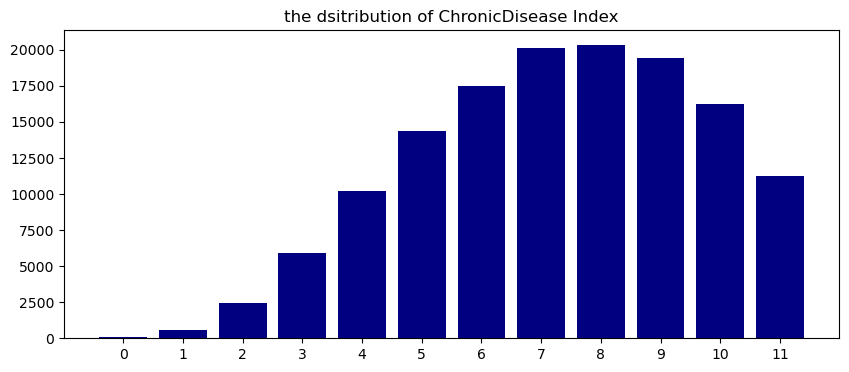

In [25]:
fig, ax = plt.subplots(figsize=(10,4),dpi=100)
data = df_train.groupby('ChronicDiseaseIndex').count().BeneID
plt.title('the dsitribution of ChronicDisease Index')
plt.bar(x=data.index,height=data,color='navy')
plt.xticks(np.arange(0,12,1))
plt.show()

In [26]:
bene_train = df_train.copy()
bene_test = df_train.copy()


In [27]:
#labelencoder = LabelEncoder()

for df in [bene_train,bene_test]:
    for col in ['Race','State','County']:
        df[col] = LabelEncoder().fit_transform(df[col])


In [28]:
#bene_train.drop(diseases,axis=1,inplace=True)
bene_train.columns

Index(['BeneID', 'DOB', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State',
       'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'Alive',
       'ChronicDiseaseIndex'],
      dtype='object')

#  Inpatient data and Outpatient data

In [29]:
inp_train.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


### ClaimStartDt  ClaimEndDt


In [30]:
for df in [inp_train,inp_test,outp_test,outp_train]:  
        for col in ['ClaimStartDt','ClaimEndDt']:
            df[col] = pd.to_datetime(df[col])
            
        df['ClaimPeriod'] =  round(((df.ClaimEndDt - df.ClaimStartDt).dt.days),0)
        

            
for df in [inp_train,inp_test]:
            df.AdmissionDt = pd.to_datetime(df.AdmissionDt)
            df.DischargeDt = pd.to_datetime(df.DischargeDt)
            ### 住院案例DischargeDt和AdmissionDt字段通过相减获得住院时间字段。并且删除原本字段。
            df['TimeInHptal'] =  round(((df.DischargeDt - df.AdmissionDt).dt.days),0)
            df.drop(['DischargeDt','AdmissionDt'],axis=1,inplace=True)
#             delta = df.DischargeDt - df.AdmissionDt
#             delta_as_time_obj = time.gmtime(delta.total_seconds())
#             df['TimeInHptal'] = time.strftime('%d', delta_as_time_obj)
            
            



We create a new
 DischargeDt AdmissionDt


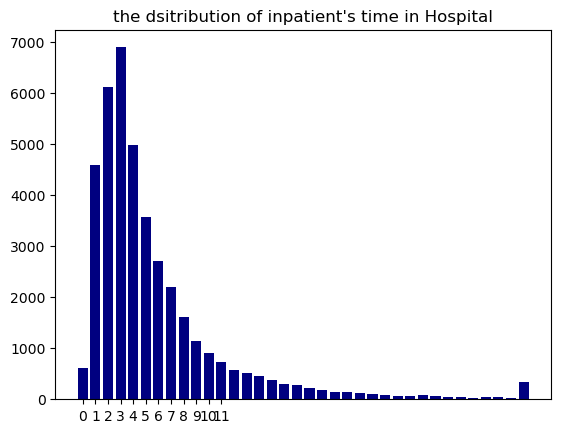

In [31]:
data = inp_train.groupby('TimeInHptal').count().BeneID
plt.title("the dsitribution of inpatient's time in Hospital")
plt.bar(x=data.index,height=data,color='navy')
plt.xticks(np.arange(0,12,1))
plt.show()

ClmDiagnosisCode 1ClmDiagnosisCode 10DiagnosisIndex，ClmDiagnosisCode 1ClmDiagnosisCode 2~ClmDiagnosisCode 10


In [32]:
ClmProcedureCode = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
        'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',]

In [33]:
ClmDiagnosisCode = ['ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']

In [34]:
for code in ClmDiagnosisCode:
    inp_train.fillna('-1',inplace=True)
    outp_train.fillna('-1',inplace=True)

In [35]:
def CountingIndex(df,codeList,indexName):    
    for i in range(df.shape[0]):#
        DiagnosisCnt = 0
        for code in codeList:
            if df.loc[i,code]== '-1':               
                continue                 
            else:
                 DiagnosisCnt+=1
        df.loc[i,indexName] = DiagnosisCnt

In [36]:
CountingIndex(inp_train,ClmDiagnosisCode,'DiagnosisIndex')

In [37]:
CountingIndex(outp_train,ClmDiagnosisCode,'DiagnosisIndex')

In [38]:
CountingIndex(inp_train,ClmProcedureCode,'ProcedureIndex')


In [39]:
CountingIndex(outp_train,ClmProcedureCode,'ProcedureIndex')

In [40]:
ClmDiagnosisCode.remove('ClmDiagnosisCode_1') 
inp_train.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,...,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimPeriod,TimeInHptal,DiagnosisIndex,ProcedureIndex
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,-1,-1,7866,...,-1,-1,-1,-1,-1,-1,6,6,9.0,0.0
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,-1,6186,...,7092.0,-1,-1,-1,-1,-1,2,2,3.0,1.0
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,-1,PHY324689,29590,...,-1,-1,-1,-1,-1,-1,3,3,6.0,0.0
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,431,...,331.0,-1,-1,-1,-1,-1,8,8,9.0,1.0
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,-1,78321,...,3893.0,-1,-1,-1,-1,-1,17,17,9.0,1.0


In [41]:
CountingIndex(inp_test,ClmProcedureCode,'ProcedureIndex')
CountingIndex(inp_test,ClmDiagnosisCode,'DiagnosisIndex')

CountingIndex(outp_test,ClmProcedureCode,'ProcedureIndex')
CountingIndex(outp_test,ClmDiagnosisCode,'DiagnosisIndex')
       

In [42]:
inp_train.groupby('DiagnosisIndex').count()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,...,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimPeriod,TimeInHptal,ProcedureIndex
DiagnosisIndex,,,,,,,,,,,,,,,,,,,,,
1.0,226,226,226,226,226,226,226,226,226,226,...,226,226,226,226,226,226,226,226,226,226
2.0,450,450,450,450,450,450,450,450,450,450,...,450,450,450,450,450,450,450,450,450,450
3.0,858,858,858,858,858,858,858,858,858,858,...,858,858,858,858,858,858,858,858,858,858
4.0,1360,1360,1360,1360,1360,1360,1360,1360,1360,1360,...,1360,1360,1360,1360,1360,1360,1360,1360,1360,1360
5.0,1944,1944,1944,1944,1944,1944,1944,1944,1944,1944,...,1944,1944,1944,1944,1944,1944,1944,1944,1944,1944
6.0,2420,2420,2420,2420,2420,2420,2420,2420,2420,2420,...,2420,2420,2420,2420,2420,2420,2420,2420,2420,2420
7.0,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684,...,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684
8.0,3555,3555,3555,3555,3555,3555,3555,3555,3555,3555,...,3555,3555,3555,3555,3555,3555,3555,3555,3555,3555
9.0,23050,23050,23050,23050,23050,23050,23050,23050,23050,23050,...,23050,23050,23050,23050,23050,23050,23050,23050,23050,23050


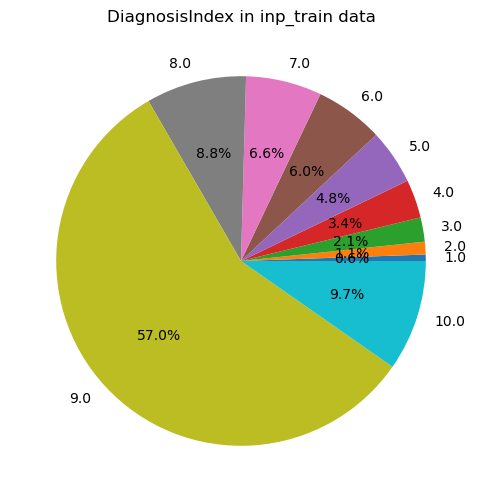

In [43]:
plt.figure(figsize=(8,6),dpi=100)

data = inp_train.groupby('DiagnosisIndex').count().BeneID

fig = plt.pie(data,
              labels=data.index,
              autopct = lambda pct: func(pct, data.values),)
plt.title('DiagnosisIndex in outpatient data')

plt.title('DiagnosisIndex in inp_train data')


plt.show()

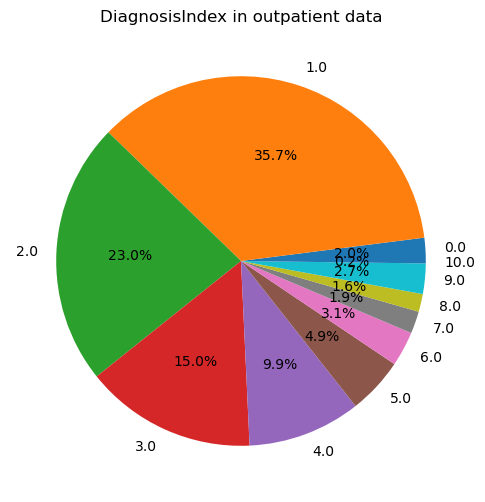

In [44]:
plt.figure(figsize=(8,6),dpi=100)
data = outp_train.groupby('DiagnosisIndex').count().BeneID




fig = plt.pie(data,
              labels=data.index,
              autopct = lambda pct: func(pct, data.values),)
plt.title('DiagnosisIndex in outpatient data')


plt.show()

In [45]:
inp_train.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'ClaimPeriod',
       'TimeInHptal', 'DiagnosisIndex', 'ProcedureIndex'],
      dtype='object')

We create a new feature: SameApplicant, it is 1 if the attending physician and the operating physician in this patient data are the same person and 0 if not

In [46]:
def isSamePhysician(df):
    for i in range(0,df.shape[0]):

        if  df.loc[i,['AttendingPhysician']][0] == df.loc[i,['OperatingPhysician']][0]:
            df.loc[i,'SamePhysician'] = 1
        else:
            df.loc[i,'SamePhysician'] = 0


In [47]:
inp_train.OtherPhysician.fillna(0,inplace=True)
outp_train.OtherPhysician.fillna(0,inplace=True)

In [48]:
inp_test.OtherPhysician.fillna(0,inplace=True)
outp_test.OtherPhysician.fillna(0,inplace=True)

In [49]:
for df in [inp_train,outp_train,inp_test,outp_train]:
    for col in ['AttendingPhysician','OperatingPhysician']:
        df[col].dropna(inplace=True)

In [50]:
isSamePhysician(inp_train)
isSamePhysician(outp_train)

In [51]:
isSamePhysician(inp_test)
isSamePhysician(outp_test)

In [52]:
bene_train.to_csv('bene_train.csv' ,sep='\t', encoding='utf-8')

In [53]:
#train_df.drop([ 'BeneID', 'DOB'],axis=1,inplace=True)  #'NoOfMonths_PartACov', 'NoOfMonths_PartBCov'

## Provider and the frauds

In [54]:
label_train

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No
...,...,...
5405,PRV57759,No
5406,PRV57760,No
5407,PRV57761,No
5408,PRV57762,No


Get the total number of the provider. We know from the data that among 5410 provider,  506 of them are marked as potential fraud data.

In [55]:
prov_num = len(label_train['Provider'].unique())
prov_num

5410

In [56]:
label_test

,Provider
0,PRV51002
1,PRV51006
2,PRV51009
3,PRV51010
4,PRV51018
...,...
1348,PRV57713
1349,PRV57726
1350,PRV57745
1351,PRV57749


In [57]:
label_train['PotentialFraud'].replace('No',0,inplace=True)
label_train['PotentialFraud'].replace('Yes',1,inplace=True)

#label_test['PotentialFraud'].replace('No',0,inplace=True)
#label_test['PotentialFraud'].replace('Yes',1,inplace=True)


fraud = label_train[label_train['PotentialFraud']==1]
fraud.shape[0]

506

We can see that it the provider data is pretty imbalance. Only about 10% of the procider are labeled as potential fraud. This may cause some challange for the supervised-learning ML process. I plan to do Random Forest first and try unsupervised learning to see how it goes compare to the RF models.

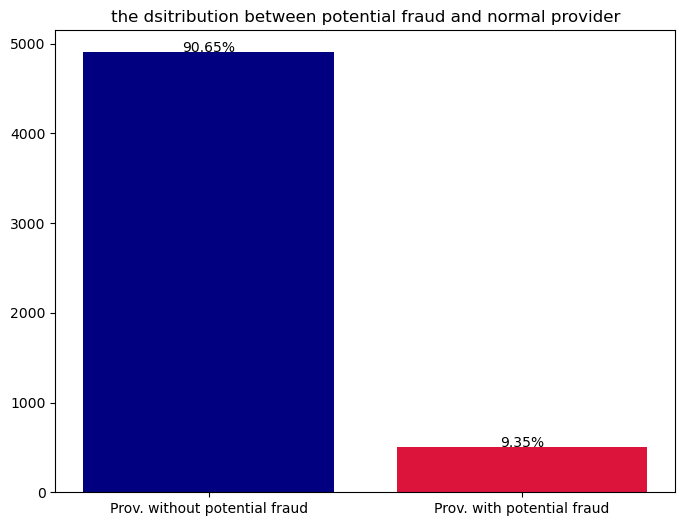

In [58]:
label_train.groupby('PotentialFraud').count()
plt.figure(figsize=(8,6),dpi=100)
data=label_train.groupby('PotentialFraud').count()
labels=['Prov. without potential fraud','Prov. with potential fraud']
fig = plt.bar(x=data.index, height = data.Provider,color=['navy','crimson'])
plt.title('the dsitribution between potential fraud and normal provider')
x_pos = np.arange(2)
plt.xticks(x_pos, labels=labels)

cnt = 0
for p in fig.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    #plt.annotate(label[cnt],(x+width/2,y+height),ha='center')
    plt.annotate(f'{str(round((100*height)/(label_train.shape[0]),2))+"%"}',(x+width/2,y+height),ha='center')
    cnt+=1

plt.show()

## Merge the dataset

In [59]:
for df in [inp_train,inp_test,outp_test,outp_train]:  
    try:
        df.drop(['ClaimStartDt','ClaimEndDt'],axis=1,inplace=True)        
    except:
        continue

In [60]:
delete = ClmProcedureCode+ClmDiagnosisCode
for df in [inp_train,inp_test,outp_test,outp_train]: 
    try:
        df.drop(delete,axis=1,inplace=True)
    except:
        continue


In [61]:
common_cols = [col for col in outp_train.columns if col in inp_train.columns]

In [62]:
common_cols

['BeneID',
 'ClaimID',
 'Provider',
 'InscClaimAmtReimbursed',
 'AttendingPhysician',
 'OperatingPhysician',
 'OtherPhysician',
 'ClmDiagnosisCode_1',
 'DeductibleAmtPaid',
 'ClmAdmitDiagnosisCode',
 'ClaimPeriod',
 'DiagnosisIndex',
 'ProcedureIndex',
 'SamePhysician']

In [63]:
inp_train["Admitted"] = 1
outp_train["Admitted"] = 0
inp_test["Admitted"] = 1
outp_test["Admitted"] = 0

In [64]:
inp_train.DeductibleAmtPaid = inp_train.DeductibleAmtPaid.astype(int)
inp_test.DeductibleAmtPaid = inp_test.DeductibleAmtPaid.fillna(-9999).astype(int)


In [65]:
ip_op_train = pd.merge(left=inp_train, right=outp_train, how='outer')
ip_op_test = pd.merge(left=inp_test, right=outp_test, how='outer')

In [66]:
ip_op_train = pd.merge(left=ip_op_train, right=label_train, on='Provider', how='inner')
ip_op_test = pd.merge(left=ip_op_test, right=label_test, on='Provider', how='inner')

In [67]:
# Joining the IP_OP dataset with the BENE data
train_df = pd.merge(left=ip_op_train, right=bene_train, left_on='BeneID', right_on='BeneID',how='inner')
train_df.shape

(558211, 33)

In [68]:
test_df = pd.merge(left=ip_op_test, right=bene_test, left_on='BeneID', right_on='BeneID',how='inner')
test_df.shape

(115531, 32)

In [69]:
outp_test.shape[0] +inp_test.BeneID.shape[0]
test_df.to_csv('test.csv' ,sep='\t', encoding='utf-8')
train_df.to_csv('train.csv' ,sep='\t', encoding='utf-8')

# Machine Learning


In [70]:
train_1 = train_df.copy()

In [71]:
train_1.columns

Index(['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClaimPeriod', 'TimeInHptal', 'DiagnosisIndex',
       'ProcedureIndex', 'SamePhysician', 'Admitted', 'PotentialFraud', 'DOB',
       'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'Alive',
       'ChronicDiseaseIndex'],
      dtype='object')

In [72]:
obj_list = ['BeneID', 'ClaimID','Provider','AttendingPhysician', 'ClmAdmitDiagnosisCode','OperatingPhysician', 'OtherPhysician','DiagnosisGroupCode','ClmDiagnosisCode_1','SamePhysician']

In [73]:
labelencoder = LabelEncoder()
for col in obj_list:
    train_1[col] = labelencoder.fit_transform(train_1[col])

In [74]:
# le = LabelEncoder()
# for col in ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
#        'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
#        'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
#        'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']: 
#      train_unclean_df[col].fillna('None',inplace=True)

# train_unclean_df['DeductibleAmtPaid'].fillna(0,inplace=True)
# train_unclean_df['Phy_same'].fillna(-1,inplace=True)


In [75]:
X = train_1.drop(['PotentialFraud','DOB'],axis=1)
y = train_1['PotentialFraud']

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   BeneID                    558211 non-null  int32  
 1   ClaimID                   558211 non-null  int32  
 2   Provider                  558211 non-null  int32  
 3   InscClaimAmtReimbursed    558211 non-null  int64  
 4   AttendingPhysician        558211 non-null  int32  
 5   OperatingPhysician        558211 non-null  int32  
 6   OtherPhysician            558211 non-null  int32  
 7   ClmAdmitDiagnosisCode     558211 non-null  int32  
 8   DeductibleAmtPaid         558211 non-null  int64  
 9   DiagnosisGroupCode        558211 non-null  int32  
 10  ClmDiagnosisCode_1        558211 non-null  int32  
 11  ClaimPeriod               558211 non-null  int64  
 12  TimeInHptal               40474 non-null   float64
 13  DiagnosisIndex            558211 non-null  f

In [77]:
X = X.fillna(-9999)

In [78]:
X_train, X_val, y_train, y_val = tts(X, y, test_size=0.20, stratify=y, random_state=42)
# Checking shape of each set
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((446568, 31), (111643, 31), (446568,), (111643,))

In [79]:
# Checking count of tgt labels in y_train
y_train.value_counts()

0    276332
1    170236
Name: PotentialFraud, dtype: int64

In [80]:
X_val.head()

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,...,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,Alive,ChronicDiseaseIndex
49668,98075,85879,674,30,13324,0,5291,0,0,736,...,13,12,12,77200,4772,4270,680,57.0,0,5.0
381763,11651,541129,2487,0,30061,0,17099,0,0,736,...,165,12,12,0,0,3500,220,68.0,0,8.0
284830,6196,412523,2167,3000,65302,0,0,2928,1068,231,...,12,12,12,3040,1068,1070,690,58.0,0,5.0
379765,71529,66515,1195,50,64432,0,0,2827,0,736,...,5,12,12,0,0,6800,790,66.0,0,7.0
513472,42396,251524,1285,10,49339,0,0,4054,0,736,...,68,12,12,9000,1068,1260,270,101.0,0,2.0


### Random Forest

In [81]:
#random forest model creation 
rfc = RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=123,max_depth=4) 
rfc.fit(X_train, y_train) 
#predictions 

RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=500,
                       random_state=123)

In [82]:
y_predict = rfc.predict(X_val)

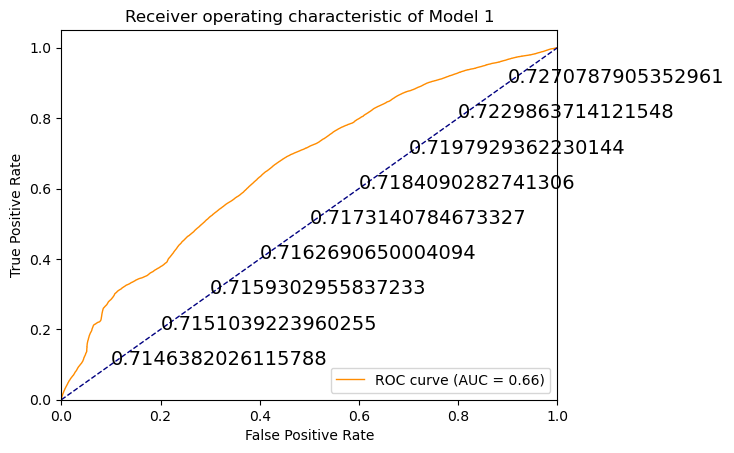

In [83]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, rfc.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})
    
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Model 1')
plt.legend(loc="lower right")
plt.show()

In [84]:
#building all kinds of evaluating parameters
from sklearn.metrics import classification_report, accuracy_score  
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import confusion_matrix 
  
n_outliers = len(fraud) 
n_errors = (y_predict != y_val).sum() 
print("The model used is Random Forest classifier") 
  
acc = accuracy_score(y_val, y_predict) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_val, y_predict) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_val,y_predict) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_val, y_predict) 
print("The F1-Score is {}".format(f1)) 
  
MCC = matthews_corrcoef(y_val, y_val) 
print("The Matthews correlation coefficient is{}".format(MCC)) 

The model used is Random Forest classifier
The accuracy is 0.6456114579507896
The precision is 0.5545279102792848
The recall is 0.3578242481203007
The F1-Score is 0.43497136655099033
The Matthews correlation coefficient is1.0


In [85]:
#random forest model creation 
rfc2 = RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=123,max_depth=10) 
rfc2.fit(X_train, y_train) 
#predictions 

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500,
                       random_state=123)

In [86]:
y_predict2 = rfc2.predict(X_val)

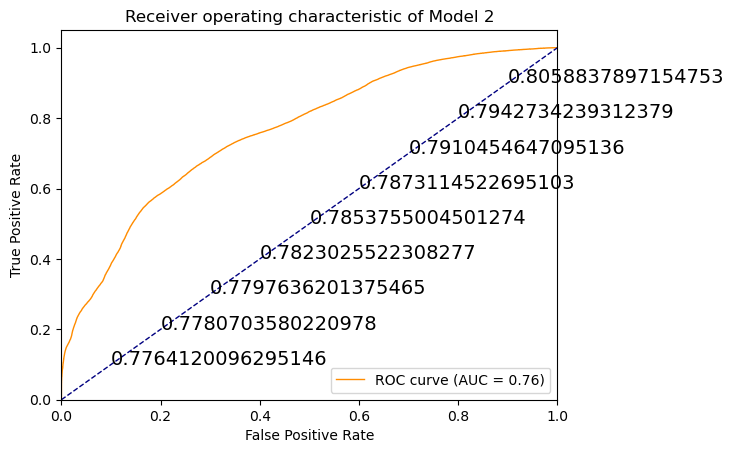

In [87]:
fpr, tpr, thresholds = roc_curve(y_val, rfc2.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})
    
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Model 2')
plt.legend(loc="lower right")
plt.show()

In [88]:
print("The model used is Random Forest classifier with depth of 10") 
  
acc = accuracy_score(y_val, y_predict2) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_val, y_predict2) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_val,y_predict2) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_val, y_predict2) 
print("The F1-Score is {}".format(f1)) 

The model used is Random Forest classifier with depth of 10
The accuracy is 0.7235473786981719
The precision is 0.6619675400210492
The recall is 0.5615836466165414
The F1-Score is 0.6076576920143392


In [89]:
#random forest model creation 
rfc3 = RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=123,max_depth=15) 
rfc3.fit(X_train, y_train) 
#predictions 
y_predict3 = rfc3.predict(X_val)

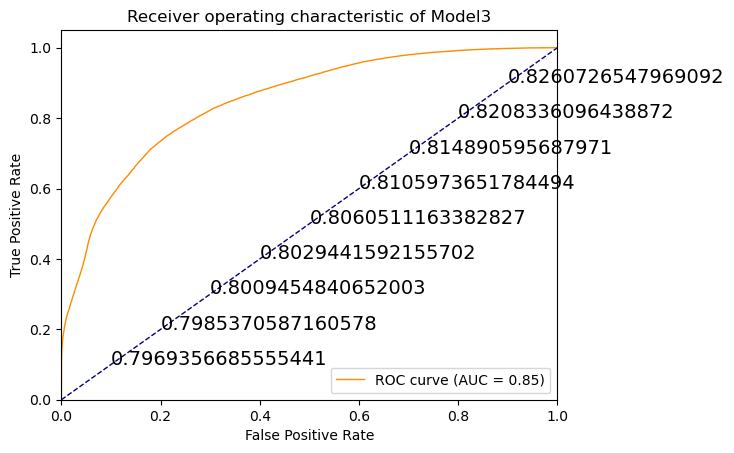

In [90]:
fpr, tpr, thresholds = roc_curve(y_val, rfc3.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})
    
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Model3')
plt.legend(loc="lower right")
plt.show()

In [91]:
print("The model used is Random Forest classifier with depth of 15") 
  
acc = accuracy_score(y_val, y_predict3) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_val, y_predict3) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_val,y_predict3) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_val, y_predict3) 
print("The F1-Score is {}".format(f1)) 

The model used is Random Forest classifier with depth of 15
The accuracy is 0.7790457081948712
The precision is 0.7344708287466583
The recall is 0.6584351503759398
The F1-Score is 0.6943776792130238


In [ ]:
#random forest model creation 
rfc4 = RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=123,max_depth=25) 
rfc4.fit(X_train, y_train) 
#predictions 
y_predict4 = rfc4.predict(X_val)

In [ ]:
print("The model used is Random Forest classifier with depth of 25") 
  
acc = accuracy_score(y_val, y_predict4) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_val, y_predict4) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_val,y_predict4) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_val, y_predict4) 
print("The F1-Score is {}".format(f1)) 

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, rfc4.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})
    
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Model 4')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#random forest model creation 
rfc5 = RandomForestClassifier(n_estimators=1000,class_weight='balanced',random_state=123,max_depth=25) 
rfc5.fit(X_train, y_train) 
#predictions 
y_predict5 = rfc5.predict(X_val)


print("The model used is Random Forest classifier with depth of 25 and estimators of 1000") 
  
acc = accuracy_score(y_val, y_predict5) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_val, y_predict5) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_val,y_predict5) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_val, y_predict5) 
print("The F1-Score is {}".format(f1)) 

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, rfc5.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})
    
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Model 5')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#random forest model creation 
rfc6 = RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=123,max_depth=25,oob_score=True) 
rfc6.fit(X_train, y_train) 
#predictions 
y_predict6 = rfc6.predict(X_val)


print("The model used is Random Forest classifier with depth of 25 and estimators of 1000") 
  
acc = accuracy_score(y_val, y_predict6) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_val, y_predict6) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_val,y_predict6) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_val, y_predict6) 
print("The F1-Score is {}".format(f1)) 

In [ ]:
cnt=0
for model in [rfc,rfc2,rfc4,rfc4,rfc5]:
    cnt+=1
    print("model",cnt)
    #print("used estimators:",model.estimators_[-1])
    print("feature_importances_",model.feature_importances_)
    print("num of feature seen during fitting :",model.n_features_in_,"\n")

## SVM

In [ ]:
from sklearn import svm

In [ ]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train) 
#predictions 
y_predict_svm = svm_model.predict(X_val)


print("The model used is SVM (Support Vector Machines)") 
  
acc = accuracy_score(y_val, y_predict_svm) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_val, y_predict_svm) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_val,y_predict_svm) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_val, y_predict_svm) 
print("The F1-Score is {}".format(f1)) 

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train) 
#predictions 
y_predict_knn = knn_model.predict(X_val)


print("The model used is SVM (Support Vector Machines)") 
  
acc = accuracy_score(y_val, y_predict_knn) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_val, y_predict_knn) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_val,y_predict_knn) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_val, y_predict_knn) 
print("The F1-Score is {}".format(f1)) 